<a href="https://colab.research.google.com/github/konstantin-larin/football-predictor/blob/main/Football_Predictor_RCF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Загружаем и импортруем все нужные библиотеки

In [1]:
!pip install kagglehub

In [50]:
import pandas as pd
import numpy as np
import kagglehub
import datetime
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Загружаем датасеты

In [4]:
def LOAD_DATA():
  path_1 = kagglehub.dataset_download("davidcariboo/player-scores")
  path_2 = kagglehub.dataset_download("adamgbor/club-football-match-data-2000-2025")
  appearances = pd.read_csv(path_1 + '/appearances.csv')
  club_games = pd.read_csv(path_1 + '/club_games.csv')
  clubs = pd.read_csv(path_1 + '/clubs.csv')
  competitions = pd.read_csv(path_1 + '/competitions.csv') #applied
  game_events = pd.read_csv(path_1 + '/game_events.csv')
  game_lineups = pd.read_csv(path_1 + '/game_lineups.csv')
  games = pd.read_csv(path_1 + '/games.csv')
  players = pd.read_csv(path_1 + '/players.csv')
  player_valuations = pd.read_csv(path_1 + '/player_valuations.csv')
  transfers = pd.read_csv(path_1 + '/transfers.csv')
  # add elo_ratings
  elo_ratings = pd.read_csv(path_2 + '/EloRatings.csv')
  DATA =  {
      'appearances': appearances,
      'club_games': club_games,
      'clubs':clubs,
      'competitions': competitions,
      'game_events': game_events,
      'game_lineups': game_lineups,
      'games': games,
      'players': players,
      "player_valuations": player_valuations,
      'transfers': transfers,
      'elo_ratings': elo_ratings
          }
  def get_dataset(name):
    return DATA[name].copy()
  return get_dataset
get_dataset = LOAD_DATA()

In [5]:
get_dataset('player_valuations')[get_dataset('player_valuations')['player_id'] == 405973].head()

,player_id,date,market_value_in_eur,current_club_id,player_club_domestic_competition_id
0,405973,2000-01-20,150000,3057,BE1
163216,405973,2016-02-07,250000,3057,BE1
177332,405973,2016-07-15,250000,3057,BE1
189510,405973,2017-01-01,150000,3057,BE1
247971,405973,2018-09-11,75000,3057,BE1


## Функция для проверки **модели**

In [6]:
  def test_model(model, X_test, y_test):
    y_pred_proba = np.clip(model.predict_proba(X_test), 1e-15, 1)
    y_pred = np.argmax(y_pred_proba, axis=1)
    #Используем метрики для оценки точности модели
    accuracy = accuracy_score(y_test, y_pred)
    print('Общая доля верно классифицированных исходов матчей:', np.round(accuracy, 2))

    precision_draw = precision_score(y_test == 0, y_pred == 0)
    print('Доля правильно предсказанных ничей:', np.round(precision_draw, 2))
    precision_1 = precision_score(y_test == 1, y_pred == 1)
    print('Доля правильно предсказанных побед домашней команды:', np.round(precision_1, 2))
    precision_2 = precision_score(y_test == 2, y_pred == 2)
    print('Доля правильно предсказанных побед гостевой команды:', np.round(precision_2, 2))

    recall_draw = recall_score(y_test == 0, y_pred == 0)
    print('Доля фактически наступивших ничей, которые были верно предсказаны:', np.round(recall_draw, 2))
    recall_1 = recall_score(y_test == 1, y_pred == 1)
    print('Доля фактически наступивших побед домашней команды, которые были верно предсказаны:', np.round(recall_1, 2))
    recall_2 = recall_score(y_test == 2, y_pred == 2)
    print('Доля фактически наступивших побед гостевой команды, которые были верно предсказаны:', np.round(recall_2, 2))

    f1_draw = f1_score(y_test == 0, y_pred == 0)
    print('F1-мера для ничей:', np.round(f1_draw, 2))
    f1_1 = f1_score(y_test == 1, y_pred == 1)
    print('F1-мера для побед домашней команды:', np.round(f1_1, 2))
    f1_2 = f1_score(y_test == 2, y_pred == 2)
    print('F1-мера для побед гостевой команды:', np.round(f1_2, 2))

    f1_average = (f1_1 + f1_2 + f1_draw) / 3
    print("Средняя F1-мера:", np.round(f1_average, 2))

    max_proba = np.max(y_pred_proba, axis=1)
    print("Средняя максимальная вероятность:", np.round(np.mean(max_proba), 2))
    sorted_proba = np.sort(y_pred_proba, axis=1)[:, ::-1]
    confidences = sorted_proba[:, 0] - sorted_proba[:, 1]
    print('Средняя уверенность в предсказании:', np.round(np.mean(confidences), 2)) # от 0 - , 1 - очень неуверенная

    predicted_count = np.unique(y_pred, return_counts=True)
    true_count = np.unique(y_test, return_counts=True)
    print("Количество предсказаний для каждого результата", predicted_count)
    print("Истинное количество результатов", true_count)

## Полезные фуннкции

In [7]:
def weighted_avg(m, n, mu=0.5, max_virtual_n=10, threshold=10):
  if n >= threshold:
    return np.round(m / n, 2)
  virtual_m = max_virtual_n / (1 - n / threshold)
  return np.round((m + virtual_m * mu) / (n + virtual_m) , 2)

## **Подготавливаем** словарь для целевой переменной

In [8]:
target_dict = {
    0: 'Ничья',
    1: 'Победа домашней команды',
    2: 'Победа г остевой команды',
}

## Достаем датасеты и обрабатываем их

In [9]:
clubs = get_dataset('clubs')
elo_ratings = get_dataset('elo_ratings')

games = get_dataset('games').dropna(subset=['home_club_id', 'away_club_id'])
games = games[games['round'] != '|']  # у команд, участвующих в таких раундах много пропусков
games.drop(columns=['round'], inplace=True)
# убираем игры с клубами, о которых нет никакой информации
games = games[(games['home_club_id'].isin(clubs['club_id'])) & (games['away_club_id'].isin(clubs['club_id']))]

# club_games.head()
games = games[games['competition_type'] != 'other']
# games = games[games['season'] >= 2023]


club_games = get_dataset('club_games')
club_games = club_games[club_games['club_id'].isin(clubs['club_id'])]
club_games['own_manager_name'] = club_games['own_manager_name'].fillna('UNKNOWN')
club_games = club_games[club_games['game_id'].isin(games['game_id'])]
def join_features_to_club_games(row):
  games_row = games[games['game_id'] == row['game_id']]
  return (games_row['date'].values[0], games_row['competition_type'].values[0])

club_games[['date', 'competition_type']] = club_games.apply(join_features_to_club_games, axis=1, result_type='expand')
club_games['date'] = pd.to_datetime(club_games['date'])
club_games = club_games.sort_values(by='date', ascending=False)
club_games.head()

,game_id,club_id,own_goals,own_position,own_manager_name,opponent_id,opponent_goals,opponent_position,opponent_manager_name,hosting,is_win,date,competition_type
26989,4547798,1041.0,2.0,NaN,Paulo Fonseca,985.0,2.0,NaN,Rúben Amorim,Home,0,2025-04-10,international_cup
101014,4547796,24.0,1.0,NaN,Dino Toppmöller,148.0,1.0,NaN,Ange Postecoglou,Away,0,2025-04-10,international_cup
26988,4547796,148.0,1.0,NaN,Ange Postecoglou,24.0,1.0,NaN,Dino Toppmöller,Home,0,2025-04-10,international_cup
87366,4547797,621.0,0.0,NaN,Ernesto Valverde,124.0,0.0,NaN,Barry Ferguson,Away,0,2025-04-10,international_cup
101015,4547798,985.0,2.0,NaN,Rúben Amorim,1041.0,2.0,NaN,Paulo Fonseca,Away,0,2025-04-10,international_cup


## Глобальные переменные


In [10]:
data_path = 'drive/MyDrive/data/football_data/'

## 1. Достаем по ID клубов полезную информацию

In [ ]:
#win_rate - отношение побед команды к общему количеству игр
#avg_goals - среднее  количество голов за игру
def prep_1(prev_data):
  data_1 = prev_data.copy()

  club_games_agg = club_games.groupby(['club_id', 'competition_type']).agg(
    wins=('is_win', 'sum'),
    games_count=('is_win', 'count'),
    scored_sum=('own_goals', 'sum'),
    missing_sum=('opponent_goals', 'sum')
  ).reset_index()

  def apply_club_games_by_id(row):
    def calc_result(df):
      games = df['games_count'].values[0]
      wins = df['wins'].values[0]
      scored = df['scored_sum'].values[0]
      missing = df['missing_sum'].values[0]

      win_rate = weighted_avg(m=wins, n=games, mu=0.5, max_virtual_n=10, threshold=10)
      lose_rate = 1 - win_rate

      scored_avg = weighted_avg(m=scored, n=games, mu=1.5, max_virtual_n=10, threshold=10)
      missing_avg = weighted_avg(m=missing, n=games, mu=1.5, max_virtual_n=10, threshold=10)

      return win_rate * scored_avg - lose_rate * missing_avg


    result = []
    home_id = row['home_club_id']
    away_id = row['away_club_id']

    home_games = club_games_agg[club_games_agg['club_id'] == home_id]

    home_league_games = home_games[home_games['competition_type'] == 'domestic_league']
    home_cup_games = home_games[home_games['competition_type'] == 'domestic_cup']
    home_international_cup_games =home_games[home_games['competition_type'] == 'international_cup']
    # home_other_games = home_games[home_games['competition_type'] == 'other']

    if not home_league_games.empty:
      result.append(calc_result(home_league_games))
    else:
      result.append(np.nan)

    if not home_cup_games.empty:
      result.append(calc_result(home_cup_games))
    else:
      result.append(np.nan)

    if not home_international_cup_games.empty:
      result.append(calc_result(home_international_cup_games))
    else:
      result.append(np.nan)


    away_games = club_games_agg[club_games_agg['club_id'] == away_id]

    away_league_games = away_games[away_games['competition_type'] == 'domestic_league']
    away_cup_games = away_games[away_games['competition_type'] == 'domestic_cup']
    away_international_cup_games =away_games[away_games['competition_type'] == 'international_cup']
    # away_other_games = away_games[away_games['competition_type'] == 'other']

    if not away_league_games.empty:
      result.append(calc_result(away_league_games))
    else:
      result.append(np.nan)

    if not away_cup_games.empty:
      result.append(calc_result(away_cup_games))
    else:
      result.append(np.nan)

    if not away_international_cup_games.empty:
      result.append(calc_result(away_international_cup_games))
    else:
      result.append(np.nan)

    return result

  data_1[[
      'home_league_strength','home_cup_strength', 'home_international_cup_strength',
      'away_league_strength','away_cup_strength', 'away_international_cup_strength',
      ]] = data_1.apply(apply_club_games_by_id, axis=1, result_type='expand')
  return data_1

# data_1 = prep_1(games)
# print(data_1.dtypes)
# print(data_1.isnull().sum())
# data_1.sample(10)
# data_1.to_csv(data_path + 'data_1.csv', index=False)

##  Сформируем rate для тренеров, как это уже сделано для клубов

Для пропусков - подставляем минимальный рейтинг

In [ ]:
def prep_2(prev_data):
  data_2 = prev_data.copy()

  club_games_agg = club_games.groupby(['own_manager_name', 'competition_type']).agg(
    wins=('is_win', 'sum'),
    games_count=('is_win', 'count'),
    scored_sum=('own_goals', 'sum'),
    missing_sum=('opponent_goals', 'sum')
  ).reset_index()

  def apply_club_games_by_id(row):
    def calc_result(df):
      games = df['games_count'].values[0]
      wins = df['wins'].values[0]
      scored = df['scored_sum'].values[0]
      missing = df['missing_sum'].values[0]

      win_rate = weighted_avg(m=wins, n=games, mu=0.5, max_virtual_n=10, threshold=10)
      lose_rate = 1 - win_rate

      scored_avg = weighted_avg(m=scored, n=games, mu=1.5, max_virtual_n=10, threshold=10)
      missing_avg = weighted_avg(m=missing, n=games, mu=1.5, max_virtual_n=10, threshold=10)

      return win_rate * scored_avg - lose_rate * missing_avg


    result = []
    home_man = row['home_club_manager_name']
    away_man = row['away_club_manager_name']

    home_games = club_games_agg[club_games_agg['own_manager_name'] == home_man]

    home_league_games = home_games[home_games['competition_type'] == 'domestic_league']
    home_cup_games = home_games[home_games['competition_type'] == 'domestic_cup']
    home_international_cup_games =home_games[home_games['competition_type'] == 'international_cup']
    # home_other_games = home_games[home_games['competition_type'] == 'other']

    if not home_league_games.empty:
      result.append(calc_result(home_league_games))
    else:
      result.append(np.nan)

    if not home_cup_games.empty:
      result.append(calc_result(home_cup_games))
    else:
      result.append(np.nan)

    if not home_international_cup_games.empty:
      result.append(calc_result(home_international_cup_games))
    else:
      result.append(np.nan)


    away_games = club_games_agg[club_games_agg['own_manager_name'] == away_man]

    away_league_games = away_games[away_games['competition_type'] == 'domestic_league']
    away_cup_games = away_games[away_games['competition_type'] == 'domestic_cup']
    away_international_cup_games =away_games[away_games['competition_type'] == 'international_cup']
    # away_other_games = away_games[away_games['competition_type'] == 'other']

    if not away_league_games.empty:
      result.append(calc_result(away_league_games))
    else:
      result.append(np.nan)

    if not away_cup_games.empty:
      result.append(calc_result(away_cup_games))
    else:
      result.append(np.nan)

    if not away_international_cup_games.empty:
      result.append(calc_result(away_international_cup_games))
    else:
      result.append(np.nan)

    return result

  data_2[[
      'home_manager_league_strength','home_manager_cup_strength', 'home_manager_international_cup_strength',
      'away_manager_league_strength','away_manager_cup_strength', 'away_manager_international_cup_strength',
      ]] = data_2.apply(apply_club_games_by_id, axis=1, result_type='expand')
  return data_2

# data_1 = pd.read_csv(data_path + 'data_1.csv')
# data_2 = prep_2(data_1)
# print(data_2.dtypes)
# print(data_2.isnull().sum())
# data_2.sample(10)
# data_2.to_csv(data_path + 'data_2.csv', index=False)

## Обработка positions

In [ ]:
def prep_3(prev_data):
  data_3 = prev_data.copy()
  # data_3['position_is_missing'] = data_3['home_club_position'].isnull().astype('int')
  # # работа с позициями
  # max_position = max(max(data_2['home_club_position'].to_numpy().reshape(-1)), max(data_2['away_club_position'].to_numpy().reshape(-1)))
  # home_mean_positions = data_2.groupby('home_club_id', as_index=False).agg({'home_club_position': 'mean'}).fillna(max_position) \
  #                     .rename(columns={'home_club_id': 'id', 'home_club_position': 'pos'})
  # home_mean_positions['pos'] = home_mean_positions['pos'].astype('float')
  # away_mean_positions = data_2.groupby('away_club_id', as_index=False).agg({'away_club_position': 'mean'}).fillna(max_position).rename(columns={'away_club_id': 'id', 'away_club_position': 'pos'})
  # away_mean_positions['pos'] = away_mean_positions['pos'].astype('float')
  # mean_positions = pd.merge(
  #   home_mean_positions,
  #   away_mean_positions,
  #   on='id',
  #   how='outer',
  #   suffixes=('_home', '_away')
  # )
  # def calc_mean_position(row):
  #   home = row['pos_home']
  #   away = row['pos_away']
  #   if pd.isna(home):
  #     return away
  #   if pd.isna(away):
  #     return home
  #   return np.round((home + away) / 2)

  # mean_positions['pos'] = mean_positions.apply(calc_mean_position, axis=1)

  # def apply_mean_position(row):
  #   home_id = row['home_club_id']
  #   away_id = row['away_club_id']
  #   if pd.isna(row['home_club_position']):
  #     row['home_club_position'] = mean_positions.loc[mean_positions['id'] == home_id, 'pos'].values[0]
  #   if pd.isna(row['away_club_position']):
  #     row['away_club_position'] = mean_positions.loc[mean_positions['id'] == away_id, 'pos'].values[0]
  #   return row

  # data_2 = data_2.apply(apply_mean_position, axis=1)
  return data_3

# data_2 = pd.read_csv(data_path + 'data_2.csv')
# data_3 = prep_3(data_2)
# data_3['home_club_position'].isnull().sum()
# data_3.to_csv(data_path + 'data_3.csv', index=False)

# data_3.head()


## Прикручиваем Elo Ratings

In [ ]:
def prep_4(prev_data):
  data_3 = prev_data.copy()
  clubs_copy = clubs.copy()

  elo_ratings_agg = elo_ratings.groupby('club', as_index=False).agg({'elo': 'mean'}).rename(columns={'club': 'club_code'})
  elo_ratings_agg['elo'] = elo_ratings_agg['elo'].astype('int')
  def club_name_to_code(x):
    x = x.lower()
    words = [word for word in list(x.split(' ')) if '.' not in word]
    return "-".join(words)
  elo_ratings_agg['club_code'] = elo_ratings_agg['club_code'].apply(club_name_to_code)

  elo_clubs = set(elo_ratings_agg['club_code'])
  min_elo = min(elo_ratings_agg['elo'].to_numpy().reshape(-1))
  def find_elo(cur_code):
      for club_code in elo_clubs:
        if club_code in cur_code:
          # elo_clubs.remove(club_code)
          return elo_ratings_agg.loc[elo_ratings_agg['club_code'] == club_code, 'elo'].values[0]
      return min_elo
  clubs_copy['elo'] = clubs_copy['club_code'].apply(find_elo)
  def apply_elo(row):
    home_id = row['home_club_id']
    away_id = row['away_club_id']
    home_elo = np.astype(clubs_copy.loc[clubs_copy['club_id'] == home_id, 'elo'].values, 'float')[0]
    away_elo = np.astype(clubs_copy.loc[clubs_copy['club_id'] == away_id, 'elo'].values, 'float')[0]
    return home_elo, away_elo

  data_3[['home_elo', 'away_elo']] = data_3.apply(apply_elo, axis=1, result_type='expand')
  return data_3
# data_3 = pd.read_csv(data_path + 'data_3.csv')
# data_4 = prep_4(data_3)
# data_4.to_csv(data_path + 'data_4.csv', index=False)

## Учтем давность матча в месяцах

In [ ]:
def prep_5(prev_data):
  data_5 = prev_data.copy()
  # работаем с давностью матча
  current_datetime = datetime.datetime.today()
  days_ago = (current_datetime - pd.to_datetime(data_5['date']) ).dt.days.astype('float')
  data_5['months_ago'] = days_ago // 30

  return data_5
# data_4 = pd.read_csv(data_path + 'data_4.csv')
# data_5 = prep_5(data_4)
# data_5.to_csv(data_path + 'data_5.csv', index=False)

## Учтем рейтинг соревнований

In [ ]:
competition_rankings_by_code = {
    'CL': 1,       # uefa-champions-league
    'USC': 2,      # uefa-super-cup
    'GB1': 3,      # premier-league
    'ES1': 4,      # laliga
    'IT1': 5,      # serie-a
    'L1': 6,       # bundesliga
    'FR1': 7,      # ligue-1
    'PO1': 8,      # liga-portugal-bwin
    'NL1': 9,      # eredivisie
    'BE1': 10,      # jupiler-pro-league
    'SC1': 11,      # scottish-premiership
    'TR1': 12,      # super-lig
    'UKR1': 13,     # premier-liga
    'GR1': 14,      # super-league-1
    'EL': 15,       # europa-league
    'UCOL': 16,     # uefa-conference-league
    'CDR': 17,      # copa-del-rey
    'FAC': 18,      # fa-cup
    'DFB': 19,      # dfb-pokal
    'CGB': 20,      # efl-cup
    'NLP': 21,      # toto-knvb-beker
    'DKP': 22,      # sydbank-pokalen
    'FRCH': 23,     # coupe-de-france (не в списке, но логично предположить)
    'UKRP': 24,     # ukrainian-cup
    'SFA': 25,      # sfa-cup
    'GRP': 26,      # kypello-elladas
    'RUP': 27,      # russian-cup
    'POCP': 28,     # allianz-cup
    'CLQ': 29,      # uefa-champions-league-qualifikation
    'ELQ': 30,      # europa-league-qualifikation
    'ECLQ': 31,     # uefa-europa-conference-league-qualifikation
    'KLUB': 32,     # fifa-klub-wm
    'GBCS': 33,     # community-shield
    'SUC': 34,      # supercopa
    'SCI': 35,      # supercoppa-italiana
    'FRCH': 36,     # trophee-des-champions
    'DFL': 37,      # dfl-supercup
    'NLSC': 38,     # johan-cruijff-schaal
    'BESC': 39,     # belgian-supercup
    'UKRS': 40,     # ukrainian-super-cup
    'RUSS': 41,     # russian-super-cup
    'DK1': 42,      # superligaen
    'POSU': 43       # supertaca-candido-de-oliveira
}

def prep_6(prev_data):
  data_6 = prev_data.copy()
  data_6['competition_rank'] = data_6['competition_id'].map(competition_rankings_by_code)
  data_6['competition_rank'] = data_6['competition_rank'].fillna(44)
  return data_6

# data_5 = pd.read_csv(data_path + 'data_5.csv')
# data_6 = prep_6(data_5)
# data_6.to_csv(data_path + 'data_6.csv', index=False)

## Учтем стоимость составов на момент игры

In [ ]:
def prep_7(prev_data):
  data_7 = prev_data.copy()
  player_valuations = get_dataset('player_valuations')
  game_lineups = get_dataset('game_lineups')

  player_valuations_players = set(player_valuations['player_id'].unique())
  game_lineups_players = set(game_lineups['player_id'].unique())
  missing_players = game_lineups_players - player_valuations_players

  min_market_value = player_valuations['market_value_in_eur'].quantile(0.25)
  if missing_players:
    player_ids = []
    dates = []
    market_values = []
    now = pd.Timestamp.today().date().strftime('%Y-%m-%d')
    for missing_id in missing_players:
      player_ids.append(missing_id)
      dates.append(now)
      market_values.append(min_market_value)

    df_1 = pd.DataFrame({
        'player_id': player_ids,
        'date': dates,
        'market_value_in_eur': min_market_value,
    })
    player_valuations = player_valuations[['player_id', 'date', 'market_value_in_eur']]

    player_valuations = pd.concat([player_valuations, df_1], ignore_index=True)

  player_valuations = player_valuations[player_valuations['player_id'].isin(game_lineups['player_id'])]


  player_valuations['date'] = pd.to_datetime(player_valuations['date'])
  game_lineups['date'] = pd.to_datetime(game_lineups['date'])
  player_valuations = player_valuations.sort_values('date').rename(columns={'date': 'player_valuations_date'})
  game_lineups = game_lineups.sort_values('date').rename(columns={'date': 'game_lineups_date'})
  game_lineups = pd.merge_asof(
      left=game_lineups,
      right=player_valuations,
      left_on='game_lineups_date',
      right_on='player_valuations_date',
      by='player_id',
      direction='nearest'
  )

  game_lineups_agg = game_lineups.groupby(['game_id', 'club_id'], as_index=False).agg(
      players_count=('player_id', 'count'),
      mean_market_value =('market_value_in_eur', 'mean')
  )

  def apply_market_value(row):
    home_id = row['home_club_id']
    away_id = row['away_club_id']
    this_game_lineups = game_lineups_agg[game_lineups_agg['game_id'] == row['game_id']]
    home_lineups = this_game_lineups[this_game_lineups['club_id'] == home_id]
    away_lineups = this_game_lineups[this_game_lineups['club_id'] == away_id]
    home_cost = min_market_value
    away_cost = min_market_value
    if not home_lineups.empty:
      home_cost = home_lineups['mean_market_value'].values[0]
    if not away_lineups.empty:
      away_cost = away_lineups['mean_market_value'].values[0]
    return home_cost, away_cost

  data_7[['home_lineups_cost', 'away_lineups_cost']] = data_7.apply(apply_market_value, axis=1, result_type='expand')

  return data_7

# data_6 = pd.read_csv(data_path + 'data_6.csv')
# data_7 = prep_7(data_6)
# data_7.to_csv(data_path + 'data_7.csv', index=False)

## One Hot Encoding для competition_type

In [ ]:
def prep_8(prev_date):
  data_8 = prev_date.copy()
  one_hot_encoded = pd.get_dummies(data_8['competition_type'], prefix='competition', dtype=int)
  print(one_hot_encoded.head())
  data_8 = pd.concat([data_8, one_hot_encoded], axis=1)
  return data_8
# data_7 = pd.read_csv(data_path + 'data_7.csv')
# data_8 = prep_8(data_7)
# data_8.to_csv(data_path + 'data_8.csv', index=False)

## Форма команды. Последние n игр

В футболе куда важнее актуальные данные. Ими и займемся!

In [72]:
def apply_last_n_results(row, n):
    home_id = row['home_club_id']
    away_id = row['away_club_id']

    last_home_games = club_games[club_games['club_id'] == home_id].head(n)
    last_home_games_results = np.where(last_home_games['own_goals'] > last_home_games['opponent_goals'], 1,
                                       np.where(last_home_games['own_goals'] == last_home_games['opponent_goals'], 0, 2))
    last_home_wins = np.sum(last_home_games_results == 1)
    last_home_draws = np.sum(last_home_games_results == 0)
    last_home_loses = np.sum(last_home_games_results == 2)

    last_away_games = club_games[club_games['club_id'] == away_id].head(n)
    last_away_games_results = np.where(last_away_games['own_goals'] > last_away_games['opponent_goals'], 1,
                                       np.where(last_away_games['own_goals'] == last_away_games['opponent_goals'], 0, 2))
    last_away_wins = np.sum(last_away_games_results == 1)
    last_away_draws = np.sum(last_away_games_results == 0)
    last_away_loses = np.sum(last_away_games_results == 2)

    return (
        last_home_wins, last_home_draws, last_home_loses,
        last_away_wins, last_away_draws, last_away_loses
    )
def prep_9(prev_date):
  data_9 = prev_date.copy()

  def apply_last_5_games(row):
      return apply_last_n_results(row, 5)
  data_9[['home_last_5_wins', 'home_last_5_draws', 'home_last_5_loses', 'away_last_5_wins', 'away_last_5_draws', 'away_last_5_loses']] \
   = data_9.apply(apply_last_5_games, axis=1, result_type='expand')

  def apply_last_10_games(row):
      return apply_last_n_results(row, 10)
  data_9[['home_last_10_wins', 'home_last_10_draws', 'home_last_10_loses', 'away_last_10_wins', 'away_last_10_draws', 'away_last_10_loses']] \
   = data_9.apply(apply_last_10_games, axis=1, result_type='expand')

  return data_9

data_9 = prep_9(pd.read_csv(data_path + 'data_8.csv'))
data_9.head()
data_9.to_csv(data_path + 'data.csv', index=False)



## Готовим выборки для модели

In [39]:
data = pd.read_csv(data_path + 'data.csv')

data['home_league_strength'] = data['home_league_strength'] * data['home_manager_league_strength']
data['home_cup_strength'] = data['home_cup_strength'] * data['home_manager_cup_strength']
data['home_international_cup_strength'] = data['home_international_cup_strength'] * data['home_manager_international_cup_strength']

data['away_league_strength'] = data['away_league_strength'] * data['away_manager_league_strength']
data['away_cup_strength'] = data['away_cup_strength'] * data['away_manager_cup_strength']
data['away_international_cup_strength'] = data['away_international_cup_strength'] * data['away_manager_international_cup_strength']

data.drop(columns=[
    'home_manager_league_strength', 'home_manager_cup_strength', 'home_manager_international_cup_strength',
    'away_manager_league_strength', 'away_manager_cup_strength', 'away_manager_international_cup_strength'
], inplace=True)

In [40]:
club_to_cat = {club_id: i for i, club_id in enumerate(clubs['club_id'])}

data['home_club_id'] = data['home_club_id'].map(club_to_cat).astype('category')
data['away_club_id'] = data['away_club_id'].map(club_to_cat).astype('category')


data['positions_diff'] = data['home_club_position'] - data['away_club_position']
data['elo_diff'] = data['home_elo'] - data['away_elo']
data['lineups_cost_diff'] = data['home_lineups_cost'] - data['away_lineups_cost']

data['league_strength_diff'] = data['home_league_strength'] - data['away_league_strength']
data['cup_strength_diff'] = data['home_cup_strength'] - data['away_cup_strength']
data['international_cup_strength_diff'] = data['home_international_cup_strength'] - data['away_international_cup_strength']

data['last_5_wins_diff'] = data['home_last_5_wins'] - data['away_last_5_wins']
data['last_5_draws_diff'] = data['home_last_5_draws'] - data['away_last_5_draws']
data['last_5_loses_diff'] = data['home_last_5_loses'] - data['away_last_5_loses']
data['last_10_wins_diff'] = data['home_last_10_wins'] - data['away_last_10_wins']
data['last_10_draws_diff'] = data['home_last_10_draws'] - data['away_last_10_draws']
data['last_10_loses_diff'] = data['home_last_10_loses'] - data['away_last_10_loses']


# считаем целевую переменную
target = np.where(data['home_club_goals'] > data['away_club_goals'], 1, np.where(data['home_club_goals'] == data['away_club_goals'], 0, 2))
# валидационная выборка будет состоять из матчей, чья давность не более 30 дней относительно текущего момента
current_datetime = datetime.datetime.today()
days_ago = (current_datetime - pd.to_datetime(data['date']) ).dt.days.astype('float')
is_recent_game = days_ago <= 30

# убираем все ненужные признаки
data.drop(columns=['url', 'aggregate', 'home_club_name', 'away_club_name', 'game_id', 'season', 'date',
                   'competition_type',
                  #  'home_club_id', 'away_club_id',

                   'home_league_strength', 'home_cup_strength', 'home_international_cup_strength',
                   'away_league_strength', 'away_cup_strength', 'away_international_cup_strength',
                   'home_club_position', 'away_club_position',
                   'home_elo', 'away_elo',
                   'home_lineups_cost', 'away_lineups_cost',
                   'home_last_5_wins', 'home_last_5_draws', 'home_last_5_loses',
                   'away_last_5_wins', 'away_last_5_draws', 'away_last_5_loses',
                   'home_last_10_wins', 'home_last_10_draws', 'home_last_10_loses',
                   'away_last_10_wins', 'away_last_10_draws', 'away_last_10_loses',

                   'home_club_goals', 'away_club_goals',
                   'stadium', 'referee', 'attendance',
                   'home_club_manager_name', 'away_club_manager_name',
                   'home_club_formation', 'away_club_formation', #также в целом состав игроков

                   'competition_id'],
          inplace=True)

# делим датасет на тренировочный, тестовый и валидационный
X_val = data[is_recent_game]
data = data[~is_recent_game]
y_val = target[is_recent_game]
target = target[~is_recent_game]
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

data.sort_values(by='months_ago', ascending=True).head()

,home_club_id,away_club_id,months_ago,competition_rank,competition_domestic_cup,competition_domestic_league,competition_international_cup,positions_diff,elo_diff,lineups_cost_diff,league_strength_diff,cup_strength_diff,international_cup_strength_diff,last_5_wins_diff,last_5_draws_diff,last_5_loses_diff,last_10_wins_diff,last_10_draws_diff,last_10_loses_diff
55495,92,272,1.0,44.0,0,1,0,9.0,-49.0,0.0,0.415533,0.055792,NaN,0,0,0,-4,-1,5
55464,428,266,1.0,11.0,0,1,0,8.0,-368.0,0.0,-0.829356,-4.726872,NaN,-2,1,1,-2,1,1
45983,392,422,1.0,14.0,0,1,0,-2.0,347.0,0.0,0.272561,NaN,NaN,0,0,0,-1,2,-1
55474,330,250,1.0,12.0,0,1,0,-4.0,-36.0,0.0,0.190617,NaN,NaN,2,1,-3,0,1,-1
27364,42,436,1.0,13.0,0,1,0,7.0,0.0,0.0,0.038478,NaN,NaN,-1,-1,2,-2,-1,3


## Типы данных у признаков

In [41]:
data.dtypes

,0
home_club_id,category
away_club_id,category
months_ago,float64
competition_rank,float64
competition_domestic_cup,int64
competition_domestic_league,int64
competition_international_cup,int64
positions_diff,float64
elo_diff,float64
lineups_cost_diff,float64


In [42]:
# np.unique((data['home_lineups_cost'] == data['away_lineups_cost']), return_counts=True)

## Пропуски в датасете

In [43]:
data.isnull().sum()

,0
home_club_id,0
away_club_id,0
months_ago,0
competition_rank,0
competition_domestic_cup,0
competition_domestic_league,0
competition_international_cup,0
positions_diff,6705
elo_diff,0
lineups_cost_diff,0


## Матрица корреляции признаков

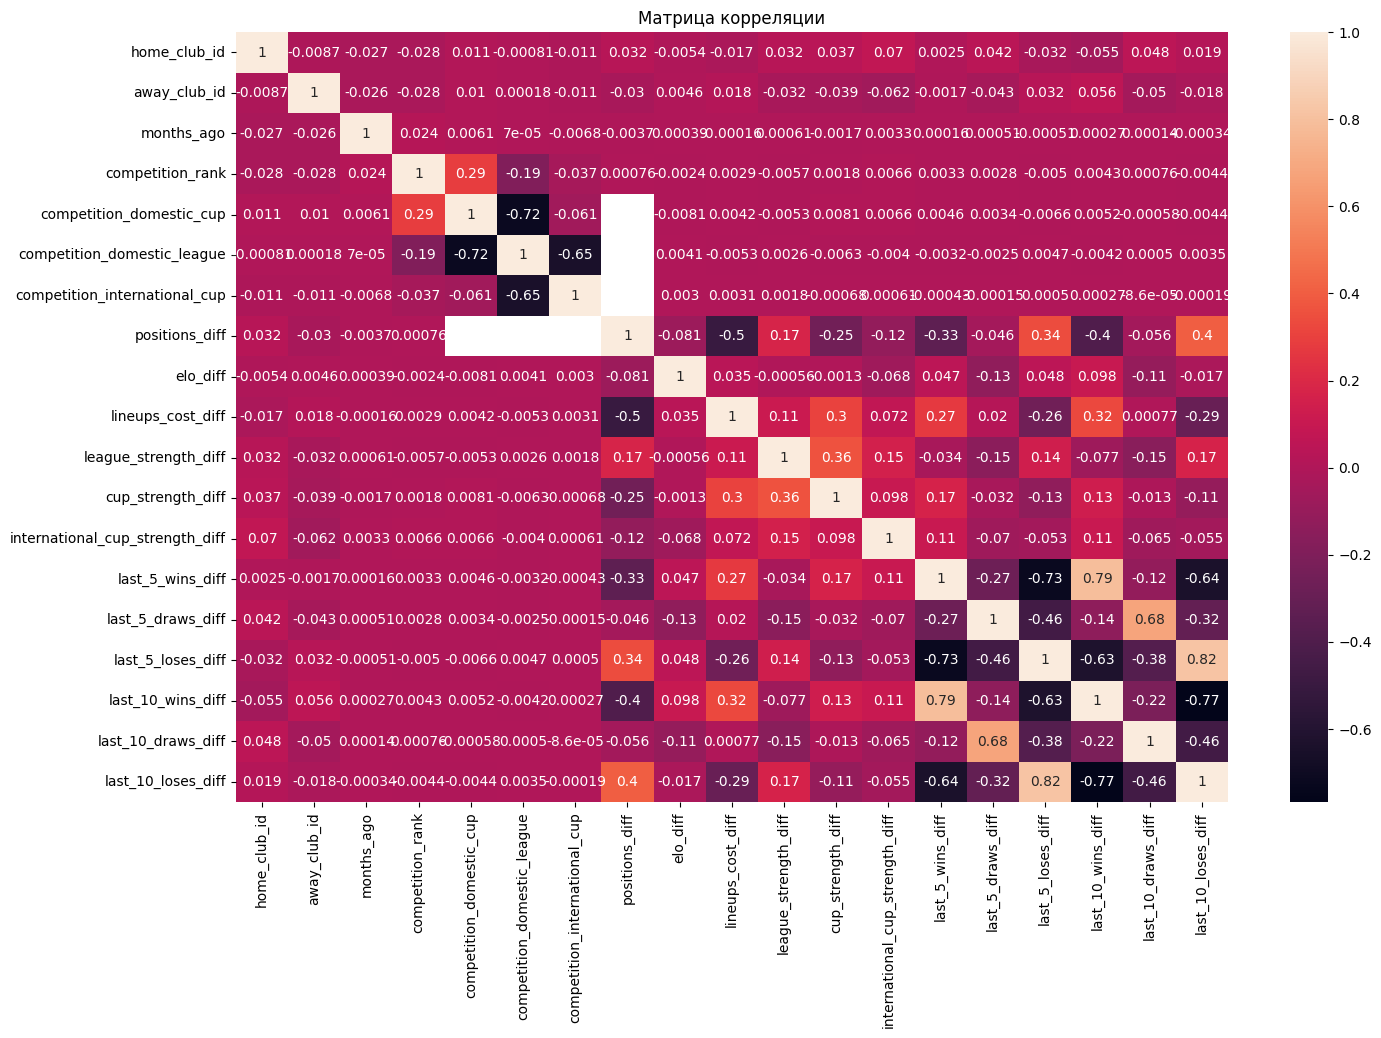

In [44]:
# матрица корреляции признаков
plt.figure(figsize=(16, 10))  # Ширина = 12 дюймов, Высота = 10 дюймов
sns.heatmap(data.corr(), annot=True)
plt.title('Матрица корреляции')
plt.show()

## Гистограммы признаков



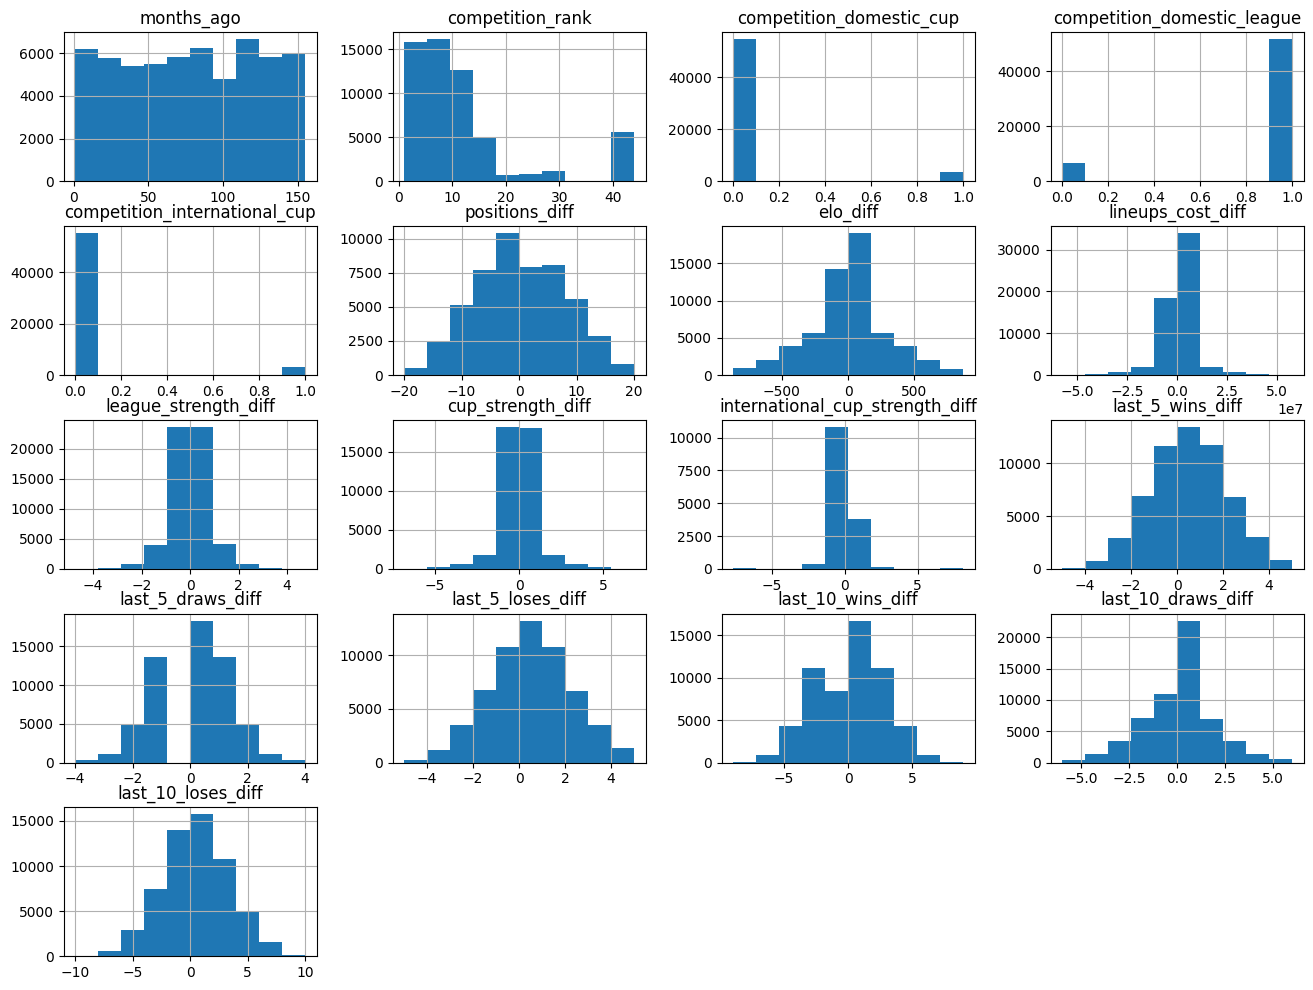

In [45]:
data.hist(figsize=(16, 12))
print()

## Обучаем RandomForestClassifier

In [46]:
features = X_train.columns
X_train, X_test, X_val = X_train.to_numpy(), X_test.to_numpy(), X_val.to_numpy()

In [52]:
rfc = RandomForestClassifier(random_state=42)
    # criterion='gini',
#     # bootstrap=True,
#     # random_state=42,
#     # class_weight='balanced_subsample',
#     # n_estimators=200,
#     # max_features='sqrt'
#     )
# # rfc.fit(X_train, y_train)
param_distributions = {
    'n_estimators': [100, 150, 200, 250, 300], # Можно задать и как распределение, например, randint(100, 301)
    'max_depth': [10, 20, 30, None],          # Включаем None, но помним про память
    'min_samples_split': [2, 5, 8, 10],        # Чуть расширенный диапазон
    'min_samples_leaf': [1, 3, 5],            # Чуть расширенный диапазон
    'max_features': ['sqrt'],         # Стандартные, быстрые опции
}


random_search = RandomizedSearchCV(
    estimator=rfc,
    param_distributions=param_distributions,
    n_iter=10,
    cv=5,
    n_jobs=1,
    verbose=2,
    scoring='f1_weighted',
    random_state=42,
)

random_search.fit(X_train, y_train)

# 5. Вывод результатов
print("\n--- Результаты RandomizedSearchCV ---")
print("Лучшие параметры:", random_search.best_params_)
# Используем ту же метрику, что и в scoring
print(f"Лучший результат ({random_search.scoring}): {random_search.best_score_:.4f}")



best_rfc = random_search.best_estimator_
feature_importances = pd.DataFrame({
    'Признак': features,
    'Важность': best_rfc.feature_importances_
})
# feature_importances

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=300; total time=  26.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=300; total time=  23.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=300; total time=  22.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=300; total time=  23.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=300; total time=  22.8s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=  11.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=  11.6s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=150

## Смотрим результаты RandomForestClassifier на тестовой выборке

In [90]:
test_model(rfc, X_test, y_test)

Общая доля верно классифицированных исходов матчей: 0.58
Доля правильно предсказанных ничей: 0.33
Доля правильно предсказанных побед домашней команды: 0.63
Доля правильно предсказанных побед гостевой команды: 0.55
Доля фактически наступивших ничей, которые были верно предсказаны: 0.13
Доля фактически наступивших побед домашней команды, которые были верно предсказаны: 0.78
Доля фактически наступивших побед гостевой команды, которые были верно предсказаны: 0.63
F1-мера для ничей: 0.18
F1-мера для побед домашней команды: 0.7
F1-мера для побед гостевой команды: 0.59
Средняя F1-мера: 0.49
Средняя максимальная вероятность: 0.59
Средняя уверенность в предсказании: 0.34
Количество предсказаний для каждого результата (array([0, 1, 2]), array([1068, 6464, 4092]))
Истинное количество результатов (array([0, 1, 2]), array([2791, 5269, 3564]))


Смотрим результаты RandomForestClassifier на валидационной выборке (актуальные матчи)

In [91]:
test_model(rfc, X_val, y_val)

Общая доля верно классифицированных исходов матчей: 0.58
Доля правильно предсказанных ничей: 0.4
Доля правильно предсказанных побед домашней команды: 0.56
Доля правильно предсказанных побед гостевой команды: 0.66
Доля фактически наступивших ничей, которые были верно предсказаны: 0.14
Доля фактически наступивших побед домашней команды, которые были верно предсказаны: 0.83
Доля фактически наступивших побед гостевой команды, которые были верно предсказаны: 0.63
F1-мера для ничей: 0.21
F1-мера для побед домашней команды: 0.67
F1-мера для побед гостевой команды: 0.64
Средняя F1-мера: 0.51
Средняя максимальная вероятность: 0.55
Средняя уверенность в предсказании: 0.27
Количество предсказаний для каждого результата (array([0, 1, 2]), array([15, 95, 56]))
Истинное количество результатов (array([0, 1, 2]), array([43, 64, 59]))


Использование модели. На вход подаются коды клубов (сделано для удобства) Из уже доступных датасетов или стороних ресурсов составляется объект. Модель делает предикт для этого объекта.

In [ ]:
def predict_match(home_code, away_code):
  x = get_object_for_predict(home_code, away_code)
  probabilities = rfc.predict_proba(x)[0]
  for i in range(len(probabilities)):
    print(f"{target_dict[i]}: {probabilities[i]}")